# Was ist ein CNN-Modell und wie funktioniert es? 
 
Ein **Convolutional Neural Network (CNN)** ist ein spezieller Typ von künstlichem neuronalen Netzwerk, der besonders gut für die Verarbeitung von Daten mit einer Gitterstruktur geeignet ist – zum Beispiel Bilder (2D-Gitter) oder Zeitreihen (1D-Gitter). Im Gegensatz zu klassischen vollvernetzten Netzwerken nutzt ein CNN sogenannte Faltungsschichten (Convolutional Layers), die lokale Muster in den Daten erkennen können. Das macht CNNs sehr leistungsfähig für Aufgaben wie Bild- oder Signalverarbeitung.
 
## Unsere Modellarchitektur
 
```python
 class CNN(nn.Module):
     def __init__(self, in_channels, out_channels, kernel_size, num_classes):
         super().__init__()
         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
         self.pool = nn.AdaptiveAvgPool1d(1)
         self.fc = nn.Linear(out_channels, num_classes)
 
     def forward(self, x):
         x = self.conv(x)
         x = self.pool(x).squeeze(-1)
         x = self.fc(x)
         return x
```
 
**Erklärung der Architektur:**
- Die erste Schicht ist eine 1D-Faltungsschicht (`nn.Conv1d`), die lokale Muster in den Eingabedaten erkennt. Die Parameter `in_channels`, `out_channels` und `kernel_size` bestimmen die Anzahl der Eingangskanäle, die Anzahl der Filter (Feature Maps) und die Größe des Faltungsfensters.
- Danach folgt ein **Adaptive Average Pooling** (`nn.AdaptiveAvgPool1d(1)`), das die Länge der Zeitachse auf 1 reduziert. Dadurch wird aus jedem Feature-Map ein einziger Wert extrahiert, unabhängig von der ursprünglichen Länge der Eingabesequenz.
- Abschließend folgt eine vollverbundene Schicht (`nn.Linear`), die die extrahierten Merkmale auf die gewünschte Anzahl an Klassen abbildet.
 
---
 
## Warum haben wir diese "Tweaks" verwendet?
 
- **Padding (`padding=kernel_size // 2`)**: Durch dieses Padding bleibt die Ausgabelänge nach der Faltung gleich der Eingabelänge ("same padding"). Das erleichtert die Architektur und verhindert, dass Informationen an den Rändern verloren gehen.
- **Adaptive Average Pooling**: Reduziert die Feature-Maps auf eine feste Größe (hier: 1), unabhängig von der Eingabelänge. Das macht das Modell flexibler für unterschiedlich lange Eingabesequenzen.
- **Einfache Architektur**: Die Architektur ist bewusst einfach gehalten, um Überanpassung (Overfitting) zu vermeiden und die wichtigsten Muster in den Daten zu extrahieren, ohne zu komplex zu werden.
- **Hyperparameter-Tuning**: Die Anzahl der Kanäle (`out_channels`) und die Kernelgröße (`kernel_size`) sind Hyperparameter, die wir im Grid Search (siehe z.B. `cnn_channels_list = [16, 32, 64, 128]` und `kernel_sizes = [3, 5, 7, 9]`) variieren, um die beste Modellkonfiguration für unsere Daten zu finden.
- **Batch Size & Learning Rate**: Auch die Batch-Größe und die Lernrate werden im Grid Search getestet, um die Trainingsdynamik optimal einzustellen.
 
Insgesamt sorgen diese Anpassungen dafür, dass das Modell sowohl leistungsfähig als auch robust gegenüber unterschiedlichen Dateneigenschaften ist.

In [17]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

log_dir = Path("../logs")

json_files = list(log_dir.glob("*.json"))

print(f"--------------------------------")
print(f"Anzahl CNN Modelle getestet: {len(json_files)}")
print(f"--------------------------------")

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        final_epoch = -1 if not data["epoch"] else data["epoch"][-1]
        results.append({
            "run_name": run_name,
            "val_acc_last": data["val_acc"][-1] if data["val_acc"] else None,
            "val_loss_last": data["val_loss"][-1] if data["val_loss"] else None,
            "train_loss_last": data["train_loss"][-1] if data["train_loss"] else None,
            "test_accuracy": data.get("test_metrics", {}).get("test_accuracy", None),
            "test_f1": data.get("test_metrics", {}).get("test_f1", None),
            "final_epoch": final_epoch
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

--------------------------------
Anzahl CNN Modelle getestet: 448
--------------------------------
Top 6 Modelle basierend auf Test-F1:
                     run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1  final_epoch
 cnn-bs-8-0.0005-cnn_c-32-k-7      0.842818       0.547707         0.698369       0.797844 0.804506           10
 cnn-bs-16-0.001-cnn_c-32-k-5      0.845528       0.566930         0.676001       0.797844 0.801457           10
 cnn-bs-8-0.0005-cnn_c-64-k-9      0.845528       0.588274         0.713135       0.784367 0.790088           10
 cnn-bs-8-0.0005-cnn_c-64-k-7      0.831978       0.552626         0.692489       0.776280 0.781469           10
  cnn-bs-8-0.001-cnn_c-64-k-9      0.826558       0.534918         0.674620       0.768194 0.778042           10
cnn-bs-8-0.0005-cnn_c-128-k-5      0.821138       0.570298         0.669599       0.773585 0.777669           10
--------------------------------
Schlechteste 3 Modelle basierend auf Tes

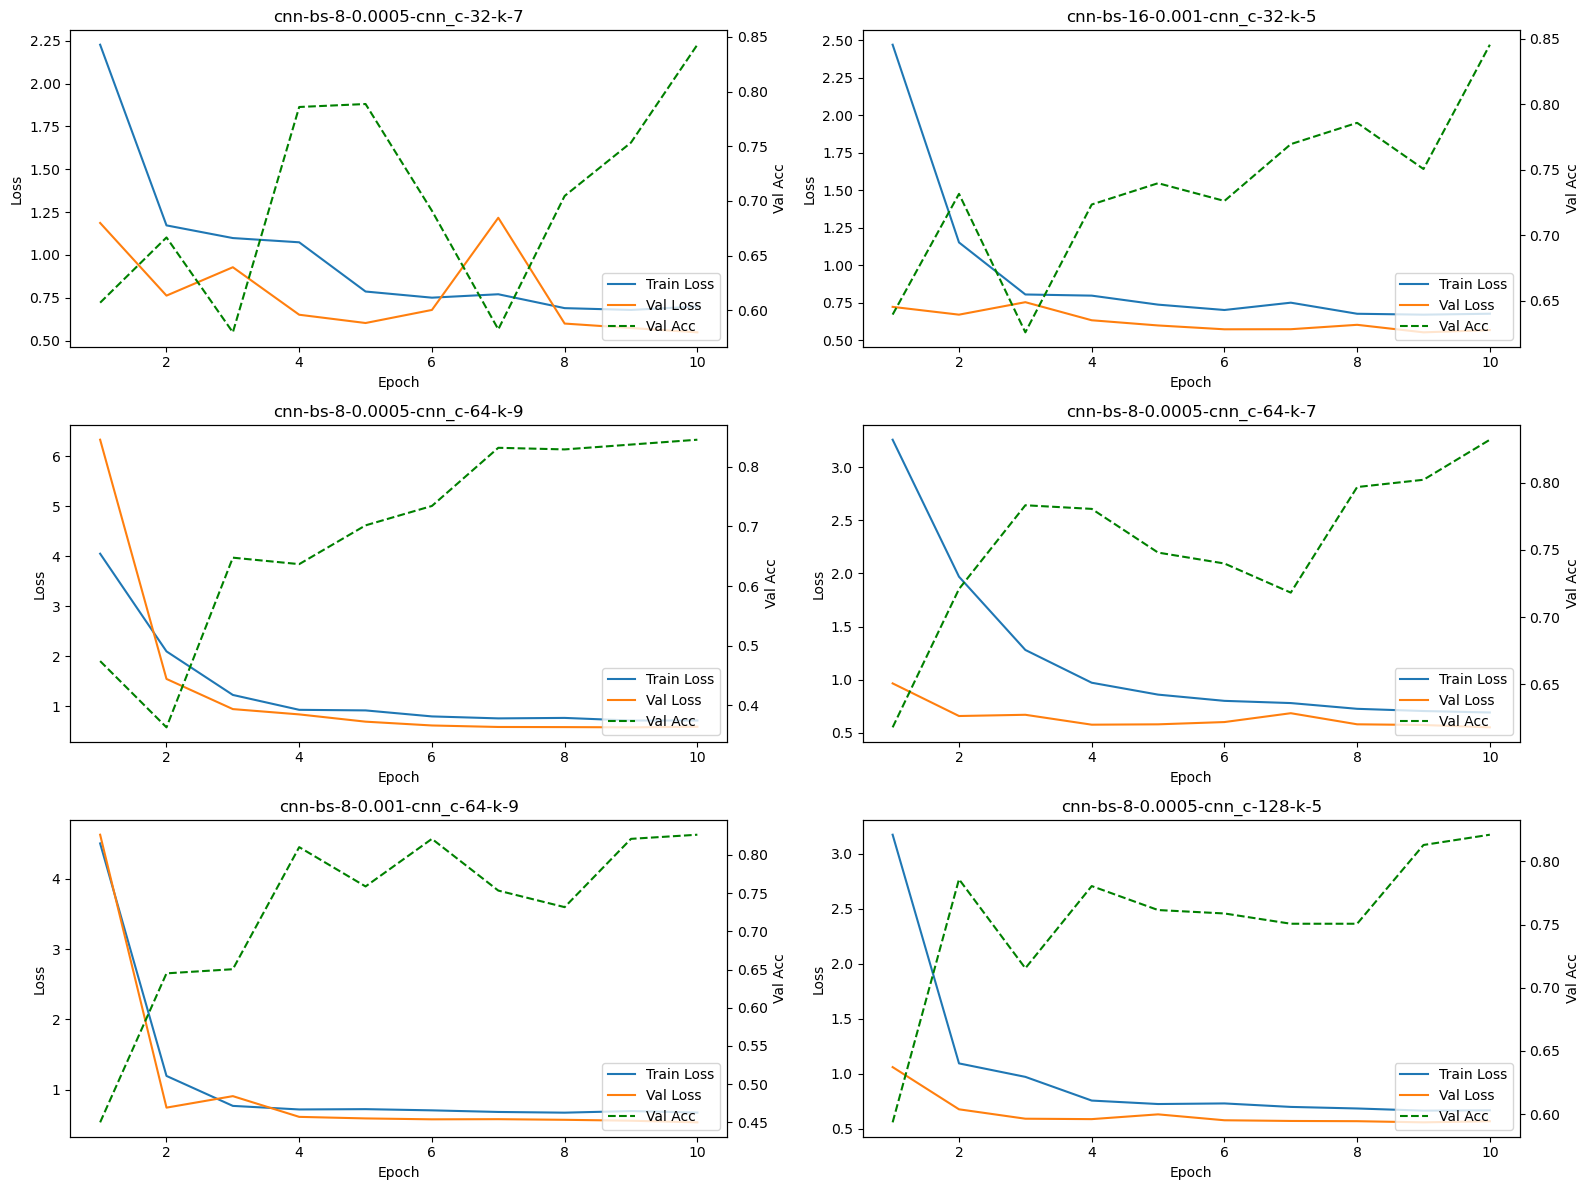

In [16]:
n_models = len(models_to_plot)
ncols = 2
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows), squeeze=False)

for idx, row in enumerate(models_to_plot.itertuples()):
    run_name = row.run_name
    data = all_data[run_name]
    row_idx = idx // ncols
    col_idx = idx % ncols
    ax = axes[row_idx, col_idx]
    epochs = data["epoch"]
    ax.plot(epochs, data["train_loss"], label="Train Loss")
    ax.plot(epochs, data["val_loss"], label="Val Loss")
    ax2 = ax.twinx()
    ax2.plot(epochs, data["val_acc"], color="green", label="Val Acc", linestyle="--")
    ax.set_title(run_name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2.set_ylabel("Val Acc")

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="lower right")

# Hide unused subplots if any
for idx in range(n_models, nrows * ncols):
    row_idx = idx // ncols
    col_idx = idx % ncols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()